In [1]:
import chainer
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers
from chainer import serializers

import os
import time, datetime
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import coordinate
import data
from model import oplus, Generator
import xp_settings as settings
settings.set_gpu(0)
xp = settings.xp


In [2]:
def plot_path(cart_path,target):
    fig = plt.figure()
    path = cart_path
    target = target
    if(settings.gpu_index >= 0):
        path = xp.asnumpy(path)
        target = xp.asnumpy(target)
    plt.scatter(target[:,0],target[:,1],c="red",s=80,marker="o")
    for i in range(1,len(path)):
        plt.quiver(path[i-1,0],path[i-1,1]
                   , path[i,0]-path[i-1,0],path[i,1]-path[i-1,1]
                   , scale_units='xy', angles='xy', scale=1,color="blue")
    num_step = len(target)
    #plt.scatter(t[num_step-1,0],t[num_step-1,1],c="yellow",s=500,marker="*")
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.axis('scaled')
    plt.grid()
    plt.show()
    return fig

In [3]:
print('Sample 1 : check Oplus')
sample_x1 = Variable(xp.array([1, 1, 1], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 2, 0], dtype = 'float32'))
print(sample_x1.shape)
sample_z = oplus(sample_x1,sample_x2)
print(sample_z)
sample_z = sample_z * xp.array([1., 1., 0], dtype='float32')
sample_zt = F.transpose(sample_z)
print(sample_zt)
sample_e = F.matmul(sample_z, sample_zt)
print(sample_e)
print(sample_e.shape)
sample_e.backward()

Sample 1 : check Oplus
(3,)
variable([-0.14263964  2.9220755   1.0000002 ])
variable([-0.14263964  2.9220755   0.        ])
variable(8.558871)
()


Sample 2 : plot Oplus
variable([1.8660254 0.5       1.0471976])
variable([2.3660254 1.3660254 1.5707963])
variable([2.3660254 2.3660254 2.094395 ])
[[1.        0.        0.5235988]
 [1.8660254 0.5       1.0471976]
 [2.3660254 1.3660254 1.5707963]
 [2.3660254 2.3660254 2.094395 ]]


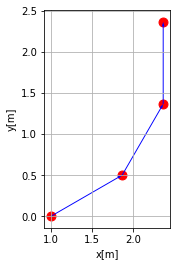

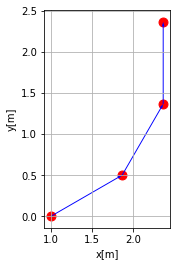

In [4]:
print('Sample 2 : plot Oplus')
sample_x1 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x3 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x4 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_z1 = oplus(sample_x1,sample_x2)
print(sample_z1)
sample_z2 = oplus(sample_z1,sample_x3)
print(sample_z2)
sample_z3 = oplus(sample_z2,sample_x4)
print(sample_z3)
sample_z = sample_z3 * xp.array([1., 1., 0], dtype='float32')
sample_pathes = xp.array(xp.vstack((sample_x1.data,sample_z1.data,sample_z2.data,sample_z3.data)),dtype='float32')
print(sample_pathes)
plot_path(sample_pathes,sample_pathes)

In [5]:
# dataset
DATA_SIZE = 1000
DATA_NUM_WAYPOINTS = 10
DATA_NUM_STEP = DATA_NUM_WAYPOINTS
DATA_HZ = 10
DATA_V_STEP = 0.5 / DATA_HZ # [m/step]
DATA_MAX_V_STEP = 1.0 / DATA_HZ # [m/step]
DATA_W_STEP = xp.pi * 0.5 / DATA_HZ # [rad/step]
DATA_MAX_W_STEP = xp.pi * 0.5 / DATA_HZ # [rad/step]
DATA_NUM_PREVIOUS_U = 1
DATA_RANGE_TRANSLATE = 0 # 経路を直進方向にずらす
DATA_RANGE_ROTATE = 0 # 経路を回転方向にずらす

params = []
params.append('DATA_SIZE            :'+str(DATA_SIZE))
params.append('DATA_NUM_WAYPOINTS   :'+str(DATA_NUM_WAYPOINTS))
params.append('DATA_NUM_STEP        :'+str(DATA_NUM_STEP))
params.append('DATA_V_STEP          :'+str(DATA_V_STEP))
params.append('DATA_MAX_V_STEP      :'+str(DATA_MAX_V_STEP))
params.append('DATA_W_STEP          :'+str(DATA_W_STEP))
params.append('DATA_MAX_W_STEP      :'+str(DATA_MAX_W_STEP))
params.append('DATA_NUM_PREVIOUS_U  :'+str(DATA_NUM_PREVIOUS_U))
params.append('DATA_RANGE_TRANSLATE :'+str(DATA_RANGE_TRANSLATE))
params.append('DATA_RANGE_ROTATE    :'+str(DATA_RANGE_ROTATE))
for a in params:
    print(a)

DATA_SIZE            :1000
DATA_NUM_WAYPOINTS   :10
DATA_NUM_STEP        :10
DATA_V_STEP          :0.05
DATA_MAX_V_STEP      :0.1
DATA_W_STEP          :0.15707963267948966
DATA_MAX_W_STEP      :0.15707963267948966
DATA_NUM_PREVIOUS_U  :1
DATA_RANGE_TRANSLATE :0
DATA_RANGE_ROTATE    :0


In [6]:
X_train = []

for i in range(DATA_SIZE):
    rand_rad = xp.random.rand()*(2*DATA_W_STEP)-DATA_W_STEP # -36 ~ 36 m/step
    d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_V_STEP)
    d = data.rotate_path(d,rand_rad*0.5)
    if DATA_RANGE_TRANSLATE != 0:
        rand_trans_x = xp.random.rand() * DATA_RANGE_TRANSLATE
        d = data.translate_path(d,rand_trans_x,0.0)
    if DATA_RANGE_ROTATE != 0:
        rand_rotate = xp.random.rand()*(DATA_RANGE_ROTATE*2)-DATA_RANGE_ROTATE
        d = data.rotate_path(d,rand_rotate)
    X_train.append(d)
'''
# old version
for i in range(DATA_SIZE):
    l = int(DATA_NUM_WAYPOINTS*DATA_M_PER_STEP)+1
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    d = data.make_arc_path_2(l,rand_rad,s=DATA_M_PER_STEP)
    d_es,_ = data.old_get_evenly_spaced_points(d,DATA_M_PER_STEP)
    d_xy = d_es[0:DATA_NUM_WAYPOINTS]
    X_train.append(d_xy)
'''
print(len(X_train))
print(X_train[0].shape)

1000
(10, 3)


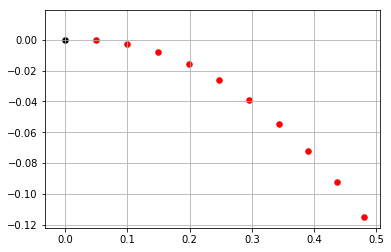

 -- x_train -- 
[[ 4.99943082e-02  1.25476952e-07 -1.64920384e+00]
 [ 9.99203425e-02 -2.61176193e-03 -1.70147384e+00]
 [ 1.49641728e-01 -7.82852776e-03 -1.75374384e+00]
 [ 1.99022650e-01 -1.56359223e-02 -1.80601384e+00]
 [ 2.47928223e-01 -2.60126193e-02 -1.85828384e+00]
 [ 2.96224858e-01 -3.89302746e-02 -1.91055384e+00]
 [ 3.43780634e-01 -5.43536032e-02 -1.96282384e+00]
 [ 3.90465649e-01 -7.22404757e-02 -2.01509384e+00]
 [ 4.36152382e-01 -9.25420338e-02 -2.06736384e+00]
 [ 4.80716039e-01 -1.15202823e-01 -2.11963384e+00]]


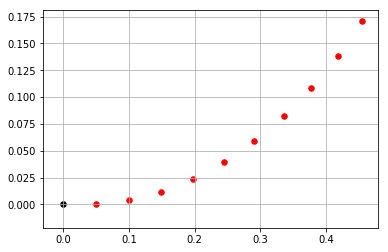

 -- x_train -- 
[[ 4.99867177e-02 -1.21154295e-07 -1.45101890e+00]
 [ 9.98141715e-02  3.98695725e-03 -1.37116890e+00]
 [ 1.49164829e-01  1.19358270e-02 -1.29131890e+00]
 [ 1.97724197e-01  2.37958329e-02 -1.21146890e+00]
 [ 2.45182824e-01  3.94913954e-02 -1.13161890e+00]
 [ 2.91238273e-01  5.89224924e-02 -1.05176890e+00]
 [ 3.35597050e-01  8.19652967e-02 -9.71918903e-01]
 [ 3.77976473e-01  1.08472965e-01 -8.92068903e-01]
 [ 4.18106473e-01  1.38276573e-01 -8.12218903e-01]
 [ 4.55731316e-01  1.71186194e-01 -7.32368903e-01]]


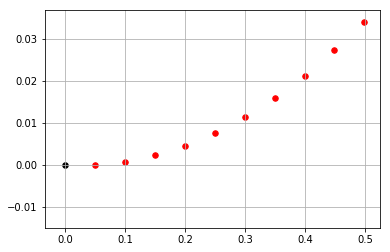

 -- x_train -- 
[[ 4.99995212e-02 -5.64430501e-08 -1.54805520e+00]
 [ 9.99932978e-02  7.57850828e-04 -1.53289520e+00]
 [ 1.49969840e-01  2.27354763e-03 -1.51773520e+00]
 [ 1.99917663e-01  4.54668562e-03 -1.50257520e+00]
 [ 2.49825286e-01  7.57674239e-03 -1.48741520e+00]
 [ 2.99681241e-01  1.13630216e-02 -1.47225520e+00]
 [ 3.49474068e-01  1.59046530e-02 -1.45709520e+00]
 [ 3.99192326e-01  2.12005929e-02 -1.44193520e+00]
 [ 4.48824587e-01  2.72496241e-02 -1.42677520e+00]
 [ 4.98359445e-01  3.40503565e-02 -1.41161520e+00]]


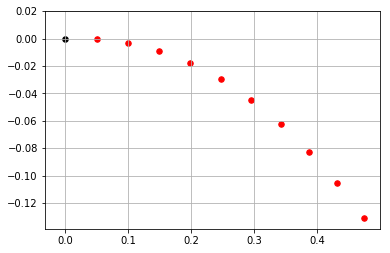

 -- x_train -- 
[[ 4.99925303e-02  1.64338619e-07 -1.66061961e+00]
 [ 9.98954703e-02 -2.99143570e-03 -1.72049961e+00]
 [ 1.49529941e-01 -8.96407659e-03 -1.78037961e+00]
 [ 1.98718024e-01 -1.78963492e-02 -1.84025961e+00]
 [ 2.47283405e-01 -2.97562353e-02 -1.90013961e+00]
 [ 2.95051998e-01 -4.45012227e-02 -1.96001961e+00]
 [ 3.41852573e-01 -6.20784573e-02 -2.01989961e+00]
 [ 3.87517374e-01 -8.24249328e-02 -2.07977961e+00]
 [ 4.31882712e-01 -1.05467716e-01 -2.13965961e+00]
 [ 4.74789558e-01 -1.31124210e-01 -2.19953961e+00]]


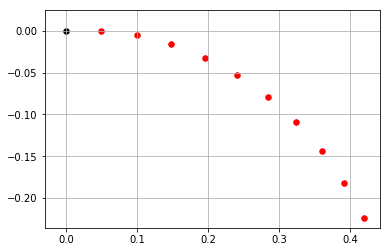

 -- x_train -- 
[[ 4.99754193e-02  1.75948194e-07 -1.73374485e+00]
 [ 9.96562806e-02 -5.41780811e-03 -1.84237485e+00]
 [ 1.48456902e-01 -1.61900802e-02 -1.95100485e+00]
 [ 1.95801980e-01 -3.21896474e-02 -2.05963485e+00]
 [ 2.41133368e-01 -5.32278927e-02 -2.16826485e+00]
 [ 2.83916661e-01 -7.90567988e-02 -2.27689485e+00]
 [ 3.23647492e-01 -1.09371872e-01 -2.38552485e+00]
 [ 3.59857477e-01 -1.43815732e-01 -2.49415485e+00]
 [ 3.92119744e-01 -1.81982323e-01 -2.60278485e+00]
 [ 4.20053955e-01 -2.23421705e-01 -2.71141485e+00]]


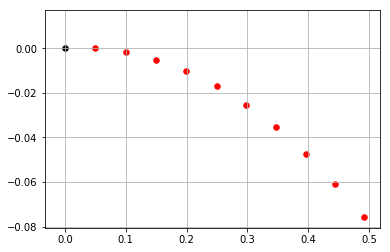

 -- x_train -- 
[[ 4.99975974e-02  4.23232824e-08 -1.62173717e+00]
 [ 9.99663683e-02 -1.69750744e-03 -1.65569717e+00]
 [ 1.49848690e-01 -5.09069173e-03 -1.68965717e+00]
 [ 1.99587040e-01 -1.01755976e-02 -1.72361717e+00]
 [ 2.49124062e-01 -1.69463613e-02 -1.75757717e+00]
 [ 2.98402630e-01 -2.53951750e-02 -1.79153717e+00]
 [ 3.47365919e-01 -3.55122958e-02 -1.82549717e+00]
 [ 3.95957464e-01 -4.72860569e-02 -1.85945717e+00]
 [ 4.44121232e-01 -6.07028811e-02 -1.89341717e+00]
 [ 4.91801682e-01 -7.57472966e-02 -1.92737717e+00]]


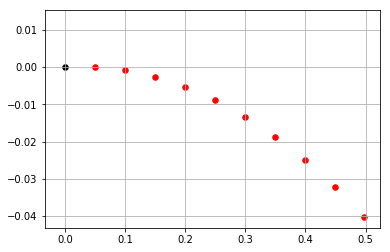

 -- x_train -- 
[[ 4.99993340e-02  2.43347401e-07 -1.59762119e+00]
 [ 9.99906803e-02 -8.93453802e-04 -1.61550119e+00]
 [ 1.49958057e-01 -2.68080575e-03 -1.63338119e+00]
 [ 1.99885491e-01 -5.36124110e-03 -1.65126119e+00]
 [ 2.49757021e-01 -8.93390295e-03 -1.66914119e+00]
 [ 2.99556704e-01 -1.33976492e-02 -1.68702119e+00]
 [ 3.49268618e-01 -1.87510528e-02 -1.70490119e+00]
 [ 3.98876873e-01 -2.49924024e-02 -1.72278119e+00]
 [ 4.48365609e-01 -3.21197027e-02 -1.74066119e+00]
 [ 4.97719005e-01 -4.01306752e-02 -1.75854119e+00]]


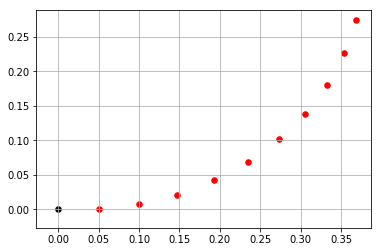

 -- x_train -- 
[[ 4.99580200e-02 -2.13824934e-07 -1.35783705e+00]
 [ 9.94134513e-02  7.06831301e-03 -1.21586705e+00]
 [ 1.47371169e-01  2.10633501e-02 -1.07389705e+00]
 [ 1.92866185e-01  4.17032941e-02 -9.31927047e-01]
 [ 2.34983064e-01  6.85728355e-02 -7.89957047e-01]
 [ 2.72874346e-01  1.01131315e-01 -6.47987047e-01]
 [ 3.05777594e-01  1.38723601e-01 -5.06017047e-01]
 [ 3.33030742e-01  1.80593276e-01 -3.64047047e-01]
 [ 3.54085411e-01  2.25897853e-01 -2.22077047e-01]
 [ 3.68517946e-01  2.73725729e-01 -8.01070467e-02]]


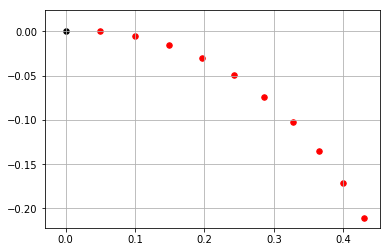

 -- x_train -- 
[[ 4.99787422e-02  1.90639961e-07 -1.72233014e+00]
 [ 9.97027029e-02 -5.03988932e-03 -1.82335014e+00]
 [ 1.48664878e-01 -1.50688494e-02 -1.92437014e+00]
 [ 1.96366033e-01 -2.99844306e-02 -2.02539014e+00]
 [ 2.42319787e-01 -4.96345483e-02 -2.12641014e+00]
 [ 2.86057581e-01 -7.38188427e-02 -2.22743014e+00]
 [ 3.27133447e-01 -1.02290722e-01 -2.32845014e+00]
 [ 3.65128561e-01 -1.34759876e-01 -2.42947014e+00]
 [ 3.99655511e-01 -1.70895238e-01 -2.53049014e+00]
 [ 4.30362247e-01 -2.10328359e-01 -2.63151014e+00]]


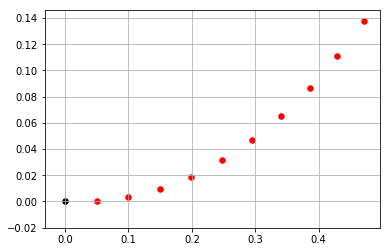

 -- x_train -- 
[[ 4.99916843e-02 -1.68274951e-07 -1.47602296e+00]
 [ 9.98836363e-02  3.15603754e-03 -1.41284296e+00]
 [ 1.49476768e-01  9.45602295e-03 -1.34966296e+00]
 [ 1.98573183e-01  1.88746486e-02 -1.28648296e+00]
 [ 2.46976969e-01  3.13743306e-02 -1.22330296e+00]
 [ 2.94494975e-01  4.69051903e-02 -1.16012296e+00]
 [ 3.40937586e-01  6.54052537e-02 -1.09694296e+00]
 [ 3.86119479e-01  8.68006984e-02 -1.03376296e+00]
 [ 4.29860360e-01  1.11006148e-01 -9.70582961e-01]
 [ 4.71985687e-01  1.37925014e-01 -9.07402961e-01]]


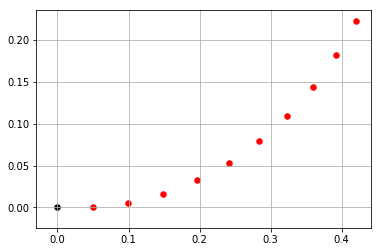

 -- x_train -- 
[[ 4.99754464e-02 -7.16102127e-08 -1.40793989e+00]
 [ 9.96566484e-02  5.41503825e-03 -1.29936989e+00]
 [ 1.48458567e-01  1.61815619e-02 -1.19079989e+00]
 [ 1.95806516e-01  3.21727143e-02 -1.08222989e+00]
 [ 2.41142933e-01  5.32001855e-02 -9.73659894e-01]
 [ 2.83933942e-01  7.90163589e-02 -8.65089894e-01]
 [ 3.23675641e-01  1.09317226e-01 -7.56519894e-01]
 [ 3.59900038e-01  1.43745969e-01 -6.47949894e-01]
 [ 3.92180558e-01  1.81897158e-01 -5.39379894e-01]
 [ 4.20137071e-01  2.23321531e-01 -4.30809894e-01]]


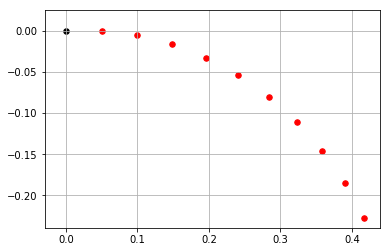

 -- x_train -- 
[[ 4.99744783e-02  9.93741971e-08 -1.73683332e+00]
 [ 9.96431296e-02 -5.52018785e-03 -1.84752332e+00]
 [ 1.48398021e-01 -1.64932946e-02 -1.95821332e+00]
 [ 1.95642403e-01 -3.27849126e-02 -2.06890332e+00]
 [ 2.40798016e-01 -5.41956362e-02 -2.17959332e+00]
 [ 2.83312166e-01 -8.04634029e-02 -2.29028332e+00]
 [ 3.22664488e-01 -1.11266701e-01 -2.40097332e+00]
 [ 3.58373320e-01 -1.46228506e-01 -2.51166332e+00]
 [ 3.90001594e-01 -1.84920893e-01 -2.62235332e+00]
 [ 4.17162186e-01 -2.26870276e-01 -2.73304332e+00]]


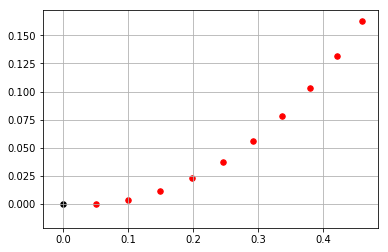

 -- x_train -- 
[[ 4.99880560e-02 -1.68393622e-07 -1.45721296e+00]
 [ 9.98328895e-02  3.78114335e-03 -1.38149296e+00]
 [ 1.49248851e-01  1.13222654e-02 -1.30577296e+00]
 [ 1.97952748e-01  2.25799811e-02 -1.23005296e+00]
 [ 2.45665469e-01  3.74897752e-02 -1.15433296e+00]
 [ 2.92113584e-01  5.59662028e-02 -1.07861296e+00]
 [ 3.37030908e-01  7.79033796e-02 -1.00289296e+00]
 [ 3.80160031e-01  1.03175588e-01 -9.27172958e-01]
 [ 4.21253788e-01  1.31638000e-01 -8.51452958e-01]
 [ 4.60076680e-01  1.63127502e-01 -7.75732958e-01]]


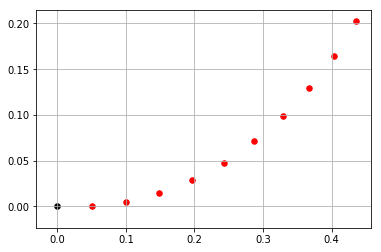

 -- x_train -- 
[[ 4.99804002e-02 -1.00271684e-07 -1.42529432e+00]
 [ 9.97258617e-02  4.84029970e-03 -1.32829432e+00]
 [ 1.48768696e-01  1.44756923e-02 -1.23129432e+00]
 [ 1.96647821e-01  2.88154891e-02 -1.13429432e+00]
 [ 2.42913096e-01  4.77248729e-02 -1.03729432e+00]
 [ 2.87129551e-01  7.10260646e-02 -9.40294321e-01]
 [ 3.28881479e-01  9.84999951e-02 -8.43294321e-01]
 [ 3.67776346e-01  1.29888365e-01 -7.46294321e-01]
 [ 4.03448475e-01  1.64896072e-01 -6.49294321e-01]
 [ 4.35562492e-01  2.03193988e-01 -5.52294321e-01]]


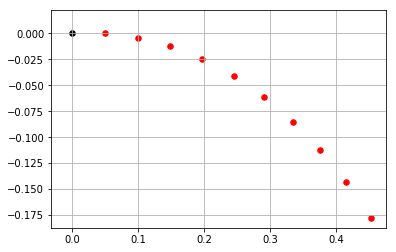

 -- x_train -- 
[[ 4.99856180e-02  1.55103733e-08 -1.69543164e+00]
 [ 9.97987875e-02 -4.14849665e-03 -1.77852164e+00]
 [ 1.49095799e-01 -1.24169118e-02 -1.86161164e+00]
 [ 1.97536504e-01 -2.47481782e-02 -1.94470164e+00]
 [ 2.44786662e-01 -4.10572102e-02 -2.02779164e+00]
 [ 2.90520249e-01 -6.12314761e-02 -2.11088164e+00]
 [ 3.34421705e-01 -8.51317737e-02 -2.19397164e+00]
 [ 3.76188109e-01 -1.12593192e-01 -2.27706164e+00]
 [ 4.15531275e-01 -1.43426247e-01 -2.36015164e+00]
 [ 4.52179736e-01 -1.77418191e-01 -2.44324164e+00]]


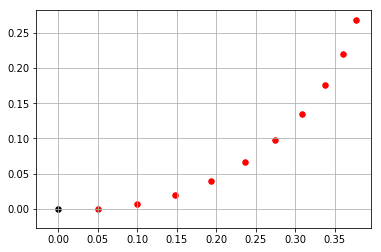

 -- x_train -- 
[[ 4.99608386e-02 -1.21595421e-08 -1.36511608e+00]
 [ 9.94527351e-02  6.82915868e-03 -1.22799608e+00]
 [ 1.47546605e-01  2.03593122e-02 -1.09087608e+00]
 [ 1.93339609e-01  4.03364543e-02 -9.53756083e-01]
 [ 2.35972099e-01  6.63855650e-02 -8.16636083e-01]
 [ 2.74643760e-01  9.80176384e-02 -6.79516083e-01]
 [ 3.08628628e-01  1.34638863e-01 -5.42396083e-01]
 [ 3.37288726e-01  1.75561769e-01 -4.05276083e-01]
 [ 3.60086032e-01  2.20018132e-01 -2.68156083e-01]
 [ 3.76592585e-01  2.67173398e-01 -1.31036083e-01]]


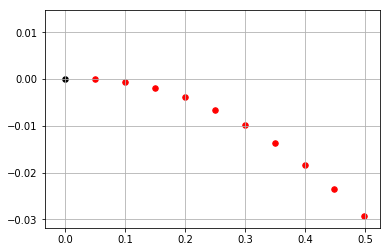

 -- x_train -- 
[[ 4.99996452e-02  1.08182861e-07 -1.59037349e+00]
 [ 9.99950343e-02 -6.52260493e-04 -1.60342349e+00]
 [ 1.49977653e-01 -1.95699493e-03 -1.61647349e+00]
 [ 1.99938990e-01 -3.91387293e-03 -1.62952349e+00]
 [ 2.49870536e-01 -6.52256124e-03 -1.64257349e+00]
 [ 2.99763787e-01 -9.78261560e-03 -1.65562349e+00]
 [ 3.49610248e-01 -1.36934808e-02 -1.66867349e+00]
 [ 3.99401429e-01 -1.82544909e-02 -1.68172349e+00]
 [ 4.49128851e-01 -2.34648690e-02 -1.69477349e+00]
 [ 4.98784045e-01 -2.93237280e-02 -1.70782349e+00]]


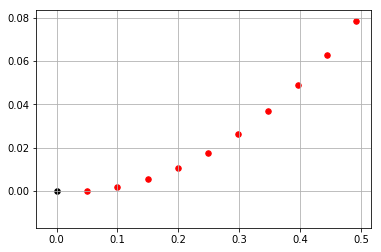

 -- x_train -- 
[[ 4.99974099e-02 -1.30762702e-07 -1.51790371e+00]
 [ 9.99637475e-02  1.76228196e-03 -1.48264371e+00]
 [ 1.49836898e-01  5.28504724e-03 -1.44738371e+00]
 [ 1.99554862e-01  1.05637858e-02 -1.41212371e+00]
 [ 2.49055832e-01  1.75919354e-02 -1.37686371e+00]
 [ 2.98278274e-01  2.63607591e-02 -1.34160371e+00]
 [ 3.47160995e-01  3.68593561e-02 -1.30634371e+00]
 [ 3.95643229e-01  4.90746751e-02 -1.27108371e+00]
 [ 4.43664704e-01  6.29915307e-02 -1.23582371e+00]
 [ 4.91165725e-01  7.85926225e-02 -1.20056371e+00]]


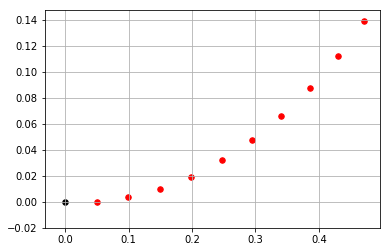

 -- x_train -- 
[[ 4.99914991e-02 -1.54492009e-09 -1.47497630e+00]
 [ 9.98810339e-02  3.19128242e-03 -1.41109630e+00]
 [ 1.49465092e-01  9.56083379e-03 -1.34721630e+00]
 [ 1.98541406e-01  1.90826695e-02 -1.28333630e+00]
 [ 2.46909781e-01  3.17179473e-02 -1.21945630e+00]
 [ 2.94372910e-01  4.74151248e-02 -1.15557630e+00]
 [ 3.40737178e-01  6.61101687e-02 -1.09169630e+00]
 [ 3.85813452e-01  8.77268171e-02 -1.02781630e+00]
 [ 4.29417855e-01  1.12176890e-01 -9.63936296e-01]
 [ 4.71372511e-01  1.39360649e-01 -9.00056296e-01]]


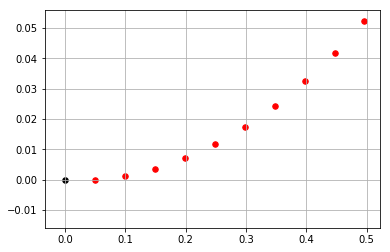

 -- x_train -- 
[[ 4.99988709e-02 -1.61702761e-07 -1.53587309e+00]
 [ 9.99841976e-02  1.16354522e-03 -1.51259309e+00]
 [ 1.49928891e-01  3.49049011e-03 -1.48931309e+00]
 [ 1.99805885e-01  6.97941193e-03 -1.46603309e+00]
 [ 2.49588149e-01  1.16284199e-02 -1.44275309e+00]
 [ 2.99248705e-01  1.74349946e-02 -1.41947309e+00]
 [ 3.48760639e-01  2.43959892e-02 -1.39619309e+00]
 [ 3.98097120e-01  3.25076313e-02 -1.37291309e+00]
 [ 4.47231411e-01  4.17655250e-02 -1.34963309e+00]
 [ 4.96136883e-01  5.21646530e-02 -1.32635309e+00]]


In [7]:
# plot data
p = X_train
random.shuffle(p)
if(settings.gpu_index >= 0):
    p = chainer.cuda.to_cpu(X_train)

for num in range(20):
    plt.scatter(0, 0,c="black",edgecolor="black",s=30,marker="o")
    plt.scatter(p[num][:,0], p[num][:,1],c="red",edgecolor="red",s=30,marker="o")
    #plt.xlim([-.2,.2])
    #plt.ylim([-.2,.2])
    plt.grid()
    plt.show()
    print(' -- x_train -- ')
    print(p[num])

In [8]:
# loss
def error_squares(z_oplus,z_true):
    w = xp.array([1., 1., 0.],dtype=xp.float32)
    t = z_true * w
    p = z_oplus * w
    error = F.sqrt(F.sum((t-p)*(t-p)))
    return error

def error_diff_v(y0, y1):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0))
    return error

def error_diff_w(y0, y1):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0))
    return error

def calc_oplus(y):
    dst = []
    z = y[0,0]
    dst.append(z)
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y[0,step])
        dst.append(z)
    return dst

def loss_function(y, y_true,disp_loss=0):
    dmesg = ''
    z_true = y_true
    z_oplus = calc_oplus(y)
    # distance - stage cost
    e_distance = error_squares(z_oplus[0],z_true[0])
    for i in range(1,DATA_NUM_WAYPOINTS-1):
        e_distance = e_distance + error_squares(z_oplus[i],z_true[i])
    # distance - terminal cost
    e_distance = e_distance + 10 * error_squares(z_oplus[-1],z_true[-1])
    dmesg = dmesg + 'e_distance: ' + str(e_distance) + '\t'
    '''
    e_diff_v = error_diff_v(y[0,0],y[0,1])
    for i in range(2,DATA_NUM_STEP):
        e_diff_v = e_diff_v + error_diff_v(y[0,i-1],y[0,i])
    dmesg = dmesg + 'e_dv: ' + str(e_diff_v) + '\t'
    e_diff_w = error_diff_v(y[0,0],y[0,1])
    for i in range(2,DATA_NUM_STEP):
        e_diff_w = e_diff_w + error_diff_w(y[0,i-1],y[0,i])
    dmesg = dmesg + 'e_dw: ' + str(e_diff_w) + '\t'
    '''    
    loss = (1 * e_distance)
    #loss = loss + (1 * e_lim_w)
    #loss = loss + (1 * e_lim_v)
    #loss = loss + (1 * e_diff_v)
    #loss = loss + (1 * e_diff_w)
    if(disp_loss):
        print(dmesg)
    return loss

In [9]:
# training
def train(model,opt,X,epoch=10,clipping=0):
    ep = 0
    AvgLoss = []
    while ep < epoch:
        random.shuffle(X)
        L = .0
        for itr in range(len(X)):
            # forward
            prev_u = xp.zeros((DATA_NUM_PREVIOUS_U,2),dtype=xp.float32)
            x = xp.vstack((X[itr][:,0:2],prev_u))
            x = xp.ravel(x)
            x = Variable(xp.array([x],dtype=xp.float32))
            y_v, y_w = model(x)
            # clip
            if clipping:
                v_limit = DATA_MAX_V_STEP
                w_limit = DATA_MAX_W_STEP
                v = F.clip(y_v,0.0,v_limit)
                w = F.clip(y_w,-w_limit,w_limit)
            else:
                v = y_v
                w = y_w
            # zero-padding
            pad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))
            y_pad = F.stack((v,pad,w),axis=2)
            
            # loss
            loss = loss_function(y_pad, X[itr][:])
            
            # update
            model.cleargrads()
            loss.backward()
            opt.update()
            #y_grad = chainer.grad( (e,), (y,) )[0]
            #print(y_grad)
            #x_grad = chainer.grad( (e,), (x,) )[0]
            #print(x_grad)
            L = L + loss.data
        ep = ep + 1
        print('Epoch:',ep,', Average loss:',L / len(X))
        AvgLoss.append(L / len(X))
    return model, AvgLoss

In [10]:
EPOCH = 10
model = Generator(DATA_NUM_WAYPOINTS,DATA_NUM_PREVIOUS_U,DATA_NUM_STEP)
start_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
if settings.gpu_index >= 0:
    cuda.cupy.cuda.Device(settings.gpu_index).use()
    model.to_gpu(settings.gpu_index)
opt = optimizers.Adam()
opt.setup(model)
model,loss_avg = train(model,opt,X_train,epoch=EPOCH,clipping=0)
model,loss_avg_clip = train(model,opt,X_train,epoch=EPOCH,clipping=1)
finish_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
print('start:',start_time)
print('finish:',finish_time)

Epoch: 1 , Average loss: 2.107314
Epoch: 2 , Average loss: 0.5365628
Epoch: 3 , Average loss: 0.33347142
Epoch: 4 , Average loss: 0.25995147
Epoch: 5 , Average loss: 0.22715546
Epoch: 6 , Average loss: 0.18983473
Epoch: 7 , Average loss: 0.17285866
Epoch: 8 , Average loss: 0.14575307
Epoch: 9 , Average loss: 0.12087089
Epoch: 10 , Average loss: 0.1077415
Epoch: 1 , Average loss: 0.14792272
Epoch: 2 , Average loss: 0.10915202
Epoch: 3 , Average loss: 0.09910753
Epoch: 4 , Average loss: 0.09031343
Epoch: 5 , Average loss: 0.08459229
Epoch: 6 , Average loss: 0.07382342
Epoch: 7 , Average loss: 0.068483956
Epoch: 8 , Average loss: 0.076773584
Epoch: 9 , Average loss: 0.066400744
Epoch: 10 , Average loss: 0.07327919
start: 2019/11/19 00:32:49
finish: 2019/11/19 00:42:11


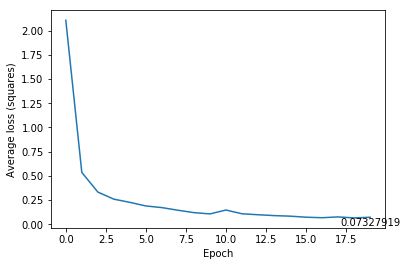

In [11]:
def plot_average_loss(loss_avg):
    fig = plt.figure()
    plt.plot(range(len(loss_avg)),loss_avg)
    plt.xlabel('Epoch')
    plt.ylabel('Average loss (squares)') #*10, lim_v, lim_w, )')
    plt.text(len(loss_avg)-1, loss_avg[-1],str(loss_avg[-1]),ha='center',va='top' )
    return fig
loss_avg.extend(loss_avg_clip)
fig = plot_average_loss(loss_avg)

In [12]:
# log
def gen_filename(header):
    name_date = '{0:%Y%m%d%H%M}'.format(datetime.datetime.now())
    name_epoch = '{}ep'.format(EPOCH)
    name_datasize  = '{}data'.format(DATA_SIZE)
    name_num_step = '{}step'.format(DATA_NUM_STEP)
    name_space = '{}mm'.format(int(DATA_V_STEP * 1000))
    fn = header + name_space + name_num_step + '_' + name_date + '_'   + name_datasize + name_epoch
    return fn
dirname = gen_filename('Weight_')
os.mkdir(dirname)
print(dirname)

Weight_50mm10step_201911190042_1000data10ep


In [14]:
f = open(dirname+'/params.txt','w')
for l in params:
    f.write(l+'\n')
f.close()
serializers.save_npz(dirname +'/'+ dirname+'.model', model)
serializers.save_npz(dirname +'/'+ dirname+'.state', opt)
fig.savefig(dirname + '/' + 'loss.png')

 --- input --- 
[[ 4.99986707e-02 -1.55938918e-07 -1.53290321e+00]
 [ 9.99813949e-02  1.26252029e-03 -1.50764321e+00]
 [ 1.49916282e-01  3.78722305e-03 -1.48238321e+00]
 [ 1.99771472e-01  7.57234151e-03 -1.45712321e+00]
 [ 2.49515155e-01  1.26154606e-02 -1.43186321e+00]
 [ 2.99115594e-01  1.89133627e-02 -1.40660321e+00]
 [ 3.48541141e-01  2.64620295e-02 -1.38134321e+00]
 [ 3.97760261e-01  3.52566447e-02 -1.35608321e+00]
 [ 4.46741551e-01  4.52915970e-02 -1.33082321e+00]
 [ 4.95453760e-01  5.65604839e-02 -1.30556321e+00]]
 --- output --- 
[[[0.05114416 0.         0.02783221]
  [0.05144558 0.         0.00884333]
  [0.05014734 0.         0.04615836]
  [0.04984673 0.         0.01635598]
  [0.0498142  0.         0.01497647]
  [0.04954406 0.         0.04823282]
  [0.05112919 0.         0.01627   ]
  [0.05044389 0.         0.01764438]
  [0.04957697 0.         0.02699973]
  [0.04987187 0.         0.08895582]]]
 --- error --- 
e_distance: variable(0.05472762)	
loss: variable(0.05472762)


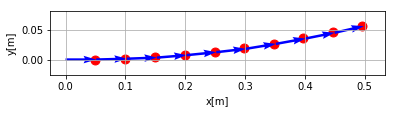

 --- grad --- 
variable([[18.653166 17.562714 16.531532 15.379748 14.323473 13.285102
           12.237562 11.197193 10.14251   9.086758]])
variable([[-1.8491275  -1.6693385  -1.4848721  -1.276858   -1.0647933
           -0.8547076  -0.6340992  -0.41898435 -0.20821638  0.        ]])


In [15]:
rand_rad = xp.random.rand()*(2*DATA_W_STEP)-DATA_W_STEP # -36 ~ 36 m/step
d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_V_STEP)
d = data.rotate_path(d,rand_rad*0.5)
if DATA_RANGE_TRANSLATE != 0:
    rand_trans_x = xp.random.rand() * DATA_RANGE_TRANSLATE
    d = data.translate_path(d,rand_trans_x,0.0)
if DATA_RANGE_ROTATE != 0:
    rand_rotate = xp.random.rand()*(DATA_RANGE_ROTATE*2)-DATA_RANGE_ROTATE
    d = data.rotate_path(d,rand_rotate)
x_test = d
'''
x_test = xp.array(
    [[ 0.02293546, -0.04092823,0],
     [ 0.05309581, -0.05415406,0],
     [ 0.08393338, -0.06682136,0],
     [ 0.11579048, -0.07606434,0],
     [ 0.14647007, -0.08932315,0],
     [ 0.17848524, -0.09797464,0],
     [ 0.21082233, -0.10660645,0],
     [ 0.24306089, -0.11521195,0],
     [ 0.27361556, -0.12854306,0],
     [ 0.3055584,  -0.13706963,0]]
    , dtype = xp.float32)
'''
prev_u = xp.array([.0,.0],dtype=xp.float32)
x = xp.vstack((x_test[:,0:2],prev_u))
x = xp.ravel(x)
x = xp.array([x],dtype=xp.float32)
y_v,y_w = model(x)
# clip
v_limit = DATA_MAX_V_STEP
w_limit = DATA_MAX_W_STEP
v = F.clip(y_v,0.0,v_limit)
w = F.clip(y_w,-w_limit,w_limit)
# zero-padding
pad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))
y_pad = F.stack((v,pad,w),axis=2)
print(' --- input --- ')
print(x_test)
print(' --- output --- ')
print(y_pad.data)
# loss
print(' --- error --- ')
loss = loss_function(y_pad, x_test, disp_loss=1)
print('loss:',loss)
z_true = x_test
z = y_pad[0,0]
Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
for step in range(1,DATA_NUM_STEP):
    z = oplus(z,y_pad[0,step])
    Z = xp.vstack((Z,z.data))
#print(' --- trajectory --- ')
#print(Z)
#print(z_true.shape)
fig = plot_path(Z,z_true)
print(' --- grad --- ')
v_grad = chainer.grad( (loss,), (y_v,) )[0]
print(v_grad)
w_grad = chainer.grad( (loss,), (y_w,) )[0]
print(w_grad)
#x_grad = chainer.grad( (loss,), (x,) )[0]
#print(x_grad)

 --- input --- 
[[ 4.99955975e-02 -1.59642450e-07 -1.50183813e+00]
 [ 9.99383853e-02  2.29716911e-03 -1.45586813e+00]
 [ 1.49722841e-01  6.88713231e-03 -1.40989813e+00]
 [ 1.99243776e-01  1.37600320e-02 -1.36392813e+00]
 [ 2.48396560e-01  2.29013465e-02 -1.31795813e+00]
 [ 2.97077338e-01  3.42917616e-02 -1.27198813e+00]
 [ 3.45183256e-01  4.79072108e-02 -1.22601813e+00]
 [ 3.92612671e-01  6.37189263e-02 -1.18004813e+00]
 [ 4.39265372e-01  8.16935002e-02 -1.13407813e+00]
 [ 4.85042787e-01  1.01792955e-01 -1.08810813e+00]]
 --- output --- 
[[[0.05114269 0.         0.04999397]
  [0.05136623 0.         0.02865847]
  [0.05018628 0.         0.0708274 ]
  [0.04988258 0.         0.03422498]
  [0.04977794 0.         0.03636419]
  [0.04965899 0.         0.07277993]
  [0.05092725 0.         0.03748575]
  [0.05041873 0.         0.03905781]
  [0.04959273 0.         0.04698092]
  [0.0498617  0.         0.09165601]]]
 --- error --- 
loss: variable(0.00114709)
loss: variable(0.00252083)
loss: variable

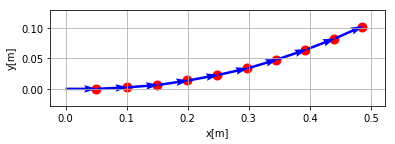

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99953174e-02  2.10462586e-07 -1.64191554e+00]
 [ 9.99344679e-02 -2.36896946e-03 -1.68932554e+00]
 [ 1.49705224e-01 -7.10221554e-03 -1.73673554e+00]
 [ 1.99195736e-01 -1.41888908e-02 -1.78414554e+00]
 [ 2.48294785e-01 -2.36130695e-02 -1.83155554e+00]
 [ 2.96892031e-01 -3.53535727e-02 -1.87896554e+00]
 [ 3.44878263e-01 -4.93840163e-02 -1.92637554e+00]
 [ 3.92145641e-01 -6.56728696e-02 -1.97378554e+00]
 [ 4.38587942e-01 -8.41835271e-02 -2.02119554e+00]
 [ 4.84100797e-01 -1.04874390e-01 -2.06860554e+00]]
 --- output --- 
[[[ 0.05047652  0.         -0.04354076]
  [ 0.04914592  0.         -0.05844657]
  [ 0.05230496  0.         -0.04018546]
  [ 0.05366009  0.         -0.0416843 ]
  [ 0.05159749  0.         -0.06343964]
  [ 0.0511575   0.         -0.03172345]
  [ 0.04661034  0.         -0.0571869 ]
  [ 0.0481448   0.         -0.06097208]
  [ 0.05054437  0.         -0.04124573]

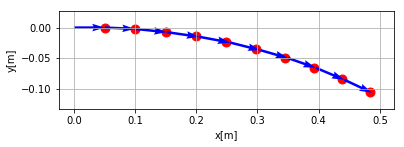

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99987052e-02  1.93606582e-07 -1.60819520e+00]
 [ 9.99818788e-02 -1.24595146e-03 -1.63312520e+00]
 [ 1.49918458e-01 -3.73766075e-03 -1.65805520e+00]
 [ 1.99777408e-01 -7.47338573e-03 -1.68298520e+00]
 [ 2.49527742e-01 -1.24508048e-02 -1.70791520e+00]
 [ 2.99138544e-01 -1.86668245e-02 -1.73284520e+00]
 [ 3.48578980e-01 -2.61175819e-02 -1.75777520e+00]
 [ 3.97818325e-01 -3.47984464e-02 -1.78270520e+00]
 [ 4.46825978e-01 -4.47040233e-02 -1.80763520e+00]
 [ 4.95571483e-01 -5.58281563e-02 -1.83256520e+00]]
 --- output --- 
[[[ 0.05055252  0.         -0.02027604]
  [ 0.04935733  0.         -0.03728346]
  [ 0.05208256  0.         -0.01345259]
  [ 0.05324471  0.         -0.02288048]
  [ 0.05136726  0.         -0.03993428]
  [ 0.05104938  0.         -0.00579668]
  [ 0.04699456  0.         -0.03435675]
  [ 0.0483929   0.         -0.03741926]
  [ 0.0504435   0.         -0.01982162]

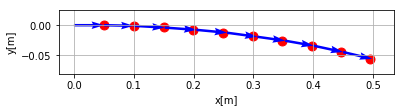

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99880402e-02  1.02609973e-07 -1.68445338e+00]
 [ 9.98326639e-02 -3.78376577e-03 -1.76022338e+00]
 [ 1.49247845e-01 -1.13298920e-02 -1.83599338e+00]
 [ 1.97950023e-01 -2.25949738e-02 -1.91176338e+00]
 [ 2.45659727e-01 -3.75143681e-02 -1.98753338e+00]
 [ 2.92103182e-01 -5.60024625e-02 -2.06330338e+00]
 [ 3.37013880e-01 -7.79531656e-02 -2.13907338e+00]
 [ 3.80134108e-01 -1.03240517e-01 -2.21484338e+00]
 [ 4.21216426e-01 -1.31719409e-01 -2.29061338e+00]
 [ 4.60025091e-01 -1.63226419e-01 -2.36638338e+00]]
 --- output --- 
[[[ 0.05054681  0.         -0.07376526]
  [ 0.04951387  0.         -0.08503111]
  [ 0.05201994  0.         -0.07321714]
  [ 0.05321219  0.         -0.06599172]
  [ 0.05147778  0.         -0.09153488]
  [ 0.05079907  0.         -0.06523478]
  [ 0.04741142  0.         -0.08552361]
  [ 0.04842092  0.         -0.08910709]
  [ 0.05041945  0.         -0.06810968]

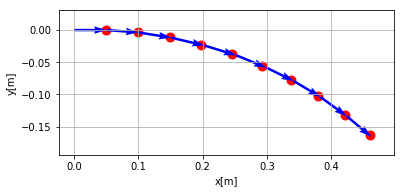

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99760800e-02  3.80304165e-08 -1.73153709e+00]
 [ 9.96654942e-02 -5.34511712e-03 -1.83869709e+00]
 [ 1.48498192e-01 -1.59741443e-02 -1.94585709e+00]
 [ 1.95913950e-01 -3.17651044e-02 -2.05301709e+00]
 [ 2.41368803e-01 -5.25368390e-02 -2.16017709e+00]
 [ 2.84341278e-01 -7.80510490e-02 -2.26733709e+00]
 [ 3.24338385e-01 -1.08015028e-01 -2.37449709e+00]
 [ 3.60901264e-01 -1.42085021e-01 -2.48165709e+00]
 [ 3.93610456e-01 -1.79870168e-01 -2.58881709e+00]
 [ 4.22090713e-01 -2.20936986e-01 -2.69597709e+00]]
 --- output --- 
[[[ 0.05079063  0.         -0.10737223]
  [ 0.05055303  0.         -0.11371928]
  [ 0.05114032  0.         -0.10828849]
  [ 0.05174601  0.         -0.09292424]
  [ 0.05093435  0.         -0.12041481]
  [ 0.04991109  0.         -0.10231952]
  [ 0.04957695  0.         -0.11575381]
  [ 0.0493145   0.         -0.11801029]
  [ 0.05002961  0.         -0.09705543]

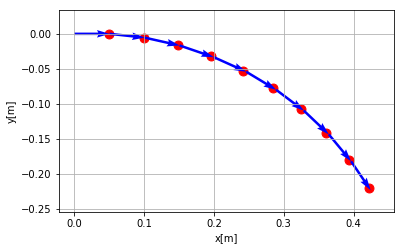

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99507217e-02  1.94569185e-08 -1.80152672e+00]
 [ 9.93116787e-02 -7.65311810e-03 -1.95534672e+00]
 [ 1.46917263e-01 -2.27786917e-02 -2.10916672e+00]
 [ 1.91643316e-01 -4.50195263e-02 -2.26298672e+00]
 [ 2.32433680e-01 -7.38504274e-02 -2.41680672e+00]
 [ 2.68325130e-01 -1.08590583e-01 -2.57062672e+00]
 [ 2.98470127e-01 -1.48419639e-01 -2.72444672e+00]
 [ 3.22156828e-01 -1.92397074e-01 -2.87826672e+00]
 [ 3.38825896e-01 -2.39484405e-01 -3.03208672e+00]
 [ 3.48083707e-01 -2.88569714e-01 -3.18590672e+00]]
 --- output --- 
[[[ 0.05146979  0.         -0.15586779]
  [ 0.05329752  0.         -0.15346985]
  [ 0.04875849  0.         -0.15569472]
  [ 0.04771597  0.         -0.13164496]
  [ 0.04933943  0.         -0.15707964]
  [ 0.04766155  0.         -0.15545687]
  [ 0.0552201   0.         -0.15694036]
  [ 0.05176279  0.         -0.15516125]
  [ 0.04897105  0.         -0.13706686]

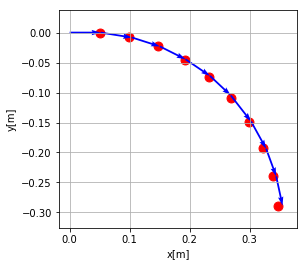

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99984779e-02 -1.06431357e-07 -1.53024920e+00]
 [ 9.99786948e-02  1.35108147e-03 -1.50321920e+00]
 [ 1.49904136e-01  4.05257656e-03 -1.47618920e+00]
 [ 1.99738328e-01  8.10240520e-03 -1.44915920e+00]
 [ 2.49444863e-01  1.34976087e-02 -1.42212920e+00]
 [ 2.98987425e-01  2.02342453e-02 -1.39509920e+00]
 [ 3.48329822e-01  2.83073936e-02 -1.36806920e+00]
 [ 3.97436003e-01  3.77111554e-02 -1.34103920e+00]
 [ 4.46270094e-01  4.84386606e-02 -1.31400920e+00]
 [ 4.94796417e-01  6.04820720e-02 -1.28697920e+00]]
 --- output --- 
[[[0.0511754  0.         0.02940598]
  [0.05155908 0.         0.01041699]
  [0.05004364 0.         0.04822555]
  [0.04966603 0.         0.01764967]
  [0.0497339  0.         0.01694462]
  [0.04945973 0.         0.05001136]
  [0.05135583 0.         0.01801931]
  [0.05055308 0.         0.01961897]
  [0.04953061 0.         0.02860039]
  [0.04987868 0.         0

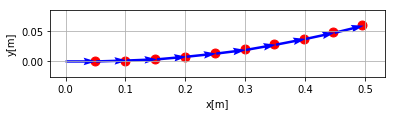

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99920950e-02 -1.28481541e-07 -1.47839376e+00]
 [ 9.98893790e-02  3.07730914e-03 -1.41679376e+00]
 [ 1.49502573e-01  9.22063903e-03 -1.35519376e+00]
 [ 1.98643478e-01  1.84065573e-02 -1.29359376e+00]
 [ 2.47125683e-01  3.06002185e-02 -1.23199376e+00]
 [ 2.94765278e-01  4.57553677e-02 -1.17039376e+00]
 [ 3.41381549e-01  6.38145159e-02 -1.10879376e+00]
 [ 3.86797664e-01  8.47091583e-02 -1.04719376e+00]
 [ 4.30841343e-01  1.08360034e-01 -9.85593757e-01]
 [ 4.73345512e-01  1.34677426e-01 -9.23993757e-01]]
 --- output --- 
[[[0.05094633 0.         0.06846563]
  [0.05055852 0.         0.04415213]
  [0.05088137 0.         0.08941931]
  [0.05105287 0.         0.04897533]
  [0.05023138 0.         0.05140926]
  [0.05033054 0.         0.09300155]
  [0.04925872 0.         0.05366987]
  [0.04970704 0.         0.05409465]
  [0.04990137 0.         0.06251172]
  [0.04980634 0.         0

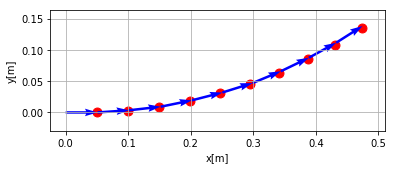

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99952798e-02 -1.05704124e-07 -1.49939421e+00]
 [ 9.99339367e-02  2.37866547e-03 -1.45179421e+00]
 [ 1.49702843e-01  7.13092480e-03 -1.40419421e+00]
 [ 1.99189256e-01  1.42459069e-02 -1.35659421e+00]
 [ 2.48281071e-01  2.37074938e-02 -1.30899421e+00]
 [ 2.96867081e-01  3.54942521e-02 -1.26139421e+00]
 [ 3.44837221e-01  4.95794807e-02 -1.21379421e+00]
 [ 3.92082823e-01  6.59312720e-02 -1.16619421e+00]
 [ 4.38496860e-01  8.45125836e-02 -1.11859421e+00]
 [ 4.83974190e-01  1.05281323e-01 -1.07099421e+00]]
 --- output --- 
[[[0.05111836 0.         0.05197766]
  [0.05126721 0.         0.03030425]
  [0.05027191 0.         0.07279218]
  [0.05002718 0.         0.03580577]
  [0.04983466 0.         0.03793266]
  [0.04974064 0.         0.07494911]
  [0.05072323 0.         0.03919804]
  [0.05033085 0.         0.04062499]
  [0.04963077 0.         0.04862959]
  [0.04985498 0.         0

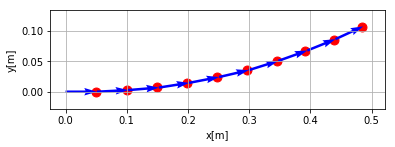

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99573671e-02 -7.08265017e-08 -1.35618991e+00]
 [ 9.94043266e-02  7.12290114e-03 -1.21311991e+00]
 [ 1.47330473e-01  2.12233641e-02 -1.07004991e+00]
 [ 1.92756476e-01  4.20131874e-02 -9.26979909e-01]
 [ 2.34754095e-01  6.90675490e-02 -7.83909909e-01]
 [ 2.72465146e-01  1.01833616e-01 -6.40839909e-01]
 [ 3.05119036e-01  1.39641843e-01 -4.97769909e-01]
 [ 3.32048510e-01  1.81719652e-01 -3.54699909e-01]
 [ 3.52703289e-01  2.27207217e-01 -2.11629909e-01]
 [ 3.66661309e-01  2.75175042e-01 -6.85599091e-02]]
 --- output --- 
[[[0.0508606  0.         0.15707964]
  [0.04989086 0.         0.134797  ]
  [0.05132977 0.         0.15707964]
  [0.0516802  0.         0.13105646]
  [0.05025899 0.         0.14840204]
  [0.05109585 0.         0.15707964]
  [0.04771591 0.         0.15035337]
  [0.04931107 0.         0.15115382]
  [0.05009389 0.         0.15363555]
  [0.04974024 0.         0

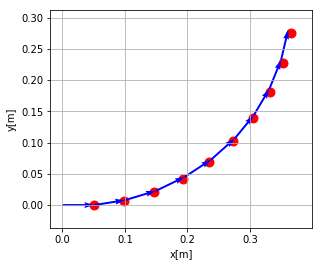

 ---------------------------------------------------------------------------------------------- 


In [16]:
for i in range(10):
    rand_rad = xp.random.rand()*(2*DATA_W_STEP)-DATA_W_STEP # -36 ~ 36 m/step
    d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_V_STEP)
    d = data.rotate_path(d,rand_rad*0.5)
    if DATA_RANGE_TRANSLATE != 0:
        rand_trans_x = xp.random.rand() * DATA_RANGE_TRANSLATE
        d = data.translate_path(d,rand_trans_x,0.0)
    if DATA_RANGE_ROTATE != 0:
        rand_rotate = xp.random.rand()*(DATA_RANGE_ROTATE*2)-DATA_RANGE_ROTATE
        d = data.rotate_path(d,rand_rotate)
    
    x_test = d
    prev_u = xp.array([.0,.0],dtype=xp.float32)
    x = xp.vstack((x_test[:,0:2],prev_u))
    x = xp.ravel(x)
    x = Variable(xp.array([x],dtype=xp.float32))
    y_v,y_w = model(x)
    # clip
    v_limit = DATA_MAX_V_STEP
    w_limit = DATA_MAX_W_STEP
    v = F.clip(y_v,0.0,v_limit)
    w = F.clip(y_w,-w_limit,w_limit)
    # zero-padding
    pad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))
    y_pad = F.stack((v,pad,w),axis=2)
    print(' --- input --- ')
    print(x_test)
    print(' --- output --- ')
    print(y_pad.data)
    # loss
    z_true = x_test
    z = y_pad[0,0]
    e = error_squares(z,z_true[0])
    print(' --- error --- ')
    print('loss:',e)
    Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y_pad[0,step])
        e = error_squares(z,z_true[step])
        print('loss:',e)
        Z = xp.vstack((Z,z.data))
    #print(' --- trajectory --- ')
    #print(Z)
    #print(z_true.shape)
    fig = plot_path(Z,z_true)
    #fig.savefig(dirname + '/test' + str(i) + '.png')
    print(' ---------------------------------------------------------------------------------------------- ')

In [ ]:
'''
x = xp.array([ 0.04362432, -0.01988486,  0.0504621,  -0.06733729,  0.01422674,
           -0.09872974, -0.03176716, -0.08520015, -0.04523301, -0.03918755,
           -0.01379037, -0.00299572,  0.03365254, -0.00989925,  0.05347693,
           -0.05355108,  0.02745634, -0.09381791, -0.02048601, -0.09367861],dtype=xp.float32)
x_test = xp.reshape(x,(10,2))
y_v =xp.array([[ 0.05098518,  0.05301605,  0.04617335,  0.05058391,  0.04857601,  0.04970181,
   0.05061447,  0.0512807,   0.05293243,  0.04999607]],dtype=xp.float32)
y_w =xp.array([[-0.0903318,  -0.09855502, -0.08380567, -0.08425293, -0.23067333, -0.0578969,
  -0.1067691,  -0.14234726, -0.06991683, -0.10047609]],dtype=xp.float32)
 
# clip
v_limit = DATA_MAX_V_STEP
w_limit = DATA_MAX_W_STEP
v = F.clip(y_v,0.0,v_limit)
w = F.clip(y_w,-w_limit,w_limit)
# zero-padding
pad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))
y_pad = F.stack((v,pad,w),axis=2)
print(' --- input --- ')
print(x_test)
print('v')
print(v)
print('w')
print(w)
print(' --- output --- ')
print(y_pad.data)
z_true = x_test
z = y_pad[0,0]
Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
for step in range(1,DATA_NUM_STEP):
    z = oplus(z,y_pad[0,step])
    Z = xp.vstack((Z,z.data))
#print(' --- trajectory --- ')
#print(Z)
#print(z_true.shape)
fig = plot_path(Z,z_true)
'''